# Mechanistic ODE scaffold

In [1]:
using Pkg
Pkg.activate("../..")
Pkg.status()

  Activating project at `~/Documents/Kaizen/code/theoretical-biology`


Status `~/Documents/Kaizen/code/theoretical-biology/Project.toml`
  [336ed68f] CSV v0.10.15
⌃ [13f3f980] CairoMakie v0.15.4
  [a93c6f00] DataFrames v1.7.0
  [0c46a032] DifferentialEquations v7.16.1
  [31c24e10] Distributions v0.25.120
  [38e38edf] GLM v1.9.0
⌃ [961ee093] ModelingToolkit v10.19.0
⌃ [91a5bcdd] Plots v1.40.16
⌃ [c3e4b0f8] Pluto v0.20.13
⌃ [7f904dfe] PlutoUI v0.7.68
  [6f49c342] RCall v0.14.9
  [f3b207a7] StatsPlots v0.15.7
  [0c5d862f] Symbolics v6.51.0
  [fdbf4ff8] XLSX v0.10.4
Info Packages marked with ⌃ have new versions available and may be upgradable.


## Loading Full Network and Truncating

In [7]:
using CSV, DataFrames

edges_full = CSV.read("output/GRN_edges_full.csv", DataFrame)
edges_full.source = uppercase.(edges.source)
edges_full.target = uppercase.(edges.target)

edges_full

578×12 DataFrame
 Row │ source   target   weight  evidence          baseMean    log2FC      lfc ⋯
     │ String   String   Int64   String31          Float64     Float64     Flo ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ ERALPHA  PGR           4  CUT&RUN_FDR<0.05   1419.67     0.723679   0.1 ⋯
   2 │ ERALPHA  NR2F1         1  CUT&RUN_FDR<0.05    500.926   -0.807142   0.2
   3 │ ERALPHA  ODC1          1  CUT&RUN_FDR<0.05    724.235    0.714085   0.2
   4 │ ERALPHA  SOX18         1  CUT&RUN_FDR<0.05    279.255    1.43359    0.4
   5 │ ERALPHA  RREB1         1  CUT&RUN_FDR<0.05   1321.48    -0.509154   0.2 ⋯
   6 │ ERALPHA  ZXDC          1  CUT&RUN_FDR<0.05    806.159    0.633613   0.2
   7 │ ERALPHA  ZSCAN20       1  CUT&RUN_FDR<0.05     68.5743  -1.12328    0.5
   8 │ ERALPHA  SMAD3         1  CUT&RUN_FDR<0.05    551.371    0.451173   0.2
  ⋮  │    ⋮        ⋮       ⋮            ⋮              ⋮           ⋮           ⋱
 572 │ MEF2A    ZEB1          1  DoRothEA_confC     3184.35     0.0433159  0.1 ⋯
 573 │ KLF5     ZFP217        1  DoRothEA_confC       94.4248  -0.567779   0.6
 574 │ SMAD3    ZFP36         3  DoRothEA_confA      153.786   -0.432948   0.5
 575 │ KLF6     ZFP36L2       1  DoRothEA_confC      211.792   -0.0263294  0.3
 576 │ MEF2A    ZFP385B       1  DoRothEA_confC     1141.89     0.104344   0.2 ⋯
 577 │ PROX1    ZFP608        1  DoRothEA_confC      940.072   -0.157578   0.2
 578 │ NR2F1    ZFYVE28       1  DoRothEA_confC      262.162    0.0622385  0.4
                                                  6 columns and 563 rows omitted

### Induce ER $_{\alpha} \to$ DEG subgraph

In [15]:
# 1) Sanity checks BEFORE any induction
deg_targets = intersect(Set(DEGs), Set(edges_full.target))
println("# DEGs present as targets in edges_full: $(length(deg_targets)) / $(length(DEGs))")
println("driver outdegree (edges from ERALPHA): ",
        sum(edges_full.source .== driver))


# DEGs present as targets in edges_full: 0 / 22
driver outdegree (edges from ERALPHA): 49


In [14]:
using Serialization

driver = "ERALPHA"

DEGs = deserialize("output/ERalphaDEGs")


# backward closure

relevant = Set(DEGs)

updated = true
while updated
    updated = false
    for r in eachrow(edges_full)
        if r.target in relevant && !(r.source in relevant)
            push!(relevant, r.source)
            updated = true
        end
    end
end

edges_back = filter(r -> r.target in relevant, edges_full)

# forward reachability

reach = Set([driver])
updated = true
while updated
    updated = false
    for r in eachrow(edges_back)
        if r.source in reach && !(r.target in reach)
            push!(reach, r.target)
            updated = true
        end
    end
end

edges = filter(
    r -> (r.source in reach) && (r.target in reach),
    edges_back
)

unreachable = setdiff(Set(DEGs), intersect(Set(DEGs), reach))

edges_back

0×12 DataFrame
 Row │ source  target  weight  evidence  baseMean  log2FC   lfcSE    stat      ⋯
     │ String  String  Int64   String31  Float64   Float64  Float64  Float64   ⋯
─────┴──────────────────────────────────────────────────────────────────────────
                                                               4 columns omitted

# Symbolic scaffolds for Hill input

$$
\begin{gather}

f_{\text{activation}}(L) = \beta\left( \frac{L^{n}}{K^{n}+ L^{n}} \right) \\

f_{\text{repression}}(L) = \beta\left( \frac{K^{n}}{K^{n} + L^{n}} \right)

\end{gather}
$$

### Defining generalised DEq for each target 

All gene expression equations will be of the same general form

In [6]:
using ModelingToolkit
using Symbolics
using DataFrames

@independent_variables t

# declare all gene state variables G(t)
genes = unique(vcat(edges.source, edges.target))
for g in genes
    @eval @variables $(Symbol(g))(t)
end

# collect parameter names (as Symbols)
β_syms = Symbol.("β_" .* unique(edges.target))
α_syms = Symbol.("α_" .* unique(edges.target))
K_syms = Symbol.("K_" .* edges.target .* "_" .* edges.source)
n_syms = Symbol.("n_" .* edges.target .* "_" .* edges.source)

# declare them with @parameters (expand the vectors at macro-expansion time)
@eval @parameters $(β_syms...) $(α_syms...) $(K_syms...) $(n_syms...)

# build node parameter table (store MTK variables, not raw Symbols)
node_params = DataFrame(
    target = unique(edges.target),
    β = [eval(b) for b in β_syms],
    α = [eval(a) for a in α_syms]
)

# build edge parameter table (store MTK variables)
edge_params = DataFrame(
    source = edges.source,
    target = edges.target,
    sign   = edges.sign,
    K = [eval(Symbol("K_"*row.target*"_"*row.source)) for row in eachrow(edges)],
    n = [eval(Symbol("n_"*row.target*"_"*row.source)) for row in eachrow(edges)]
)

# hill functions
hill_act(r, K, n) = (r^n) / (K^n + r^n)
hill_rep(r, K, n) = (K^n) / (K^n + r^n)

# production function
function production(inputs::Vector, β)
    prod_term = 1
    for input in inputs
        if input.type == :act
            prod_term *= hill_act(input.var, input.K, input.n)
        elseif input.type == :rep
            prod_term *= hill_rep(input.var, input.K, input.n)
        else
            error("Unknown regulator type: $(input.type)")
        end
    end
    return β * prod_term
end

# equation builder
function make_equation(target::AbstractString, edges::DataFrame, node_params::DataFrame, edge_params::DataFrame)
    # gene variable
    target_var = eval(Symbol(target))
    # node parameters
    β_var = eval(only(node_params[node_params.target .== target, :β]))
    α_var = eval(only(node_params[node_params.target .== target, :α]))

    # incoming edges for this target
    subedges = edges[edges.target .== target, :]

    # collect inputs
    inputs = [
        (
            type = (row.sign == "Activator" ? :act : :rep),
            var  = eval(Symbol(row.source)),
            K    = eval(only(edge_params[(edge_params.source .== row.source) .& (edge_params.target .== row.target), :K])),
            n    = eval(only(edge_params[(edge_params.source .== row.source) .& (edge_params.target .== row.target), :n]))
        )
        for row in eachrow(subedges)
    ]

    # ODE
    dG   = Differential(t)(target_var)
    prod = production(inputs, β_var)
    deg  = α_var * target_var

    return dG ~ prod - deg
end

make_equation (generic function with 1 method)

### Dummy simulation

In [ ]:
using DifferentialEquations, ModelingToolkit

# pick a subset of target genes
subset = unique(edges.target)[1:10]

# build equations
subset_eq   = [make_equation(target, edges, node_params, edge_params) for target in subset]
subset_vars = [eval(Symbol(target)) for target in subset]

# detect external regulators ("drivers")
subset_targets = Set(subset)
subset_sources = Set(edges[in.(edges.target, Ref(subset)), :source])
drivers = setdiff(subset_sources, subset_targets)  # genes that regulate but are not modeled as states

# declare them as parameters (if not already declared)
@eval @parameters $(Symbol.(drivers)...)
driver_params = [eval(Symbol(d)) for d in drivers]

# --- collect parameters for this subset ---
node_mask = in.(node_params.target, Ref(subset))
edge_mask = in.(edge_params.target, Ref(subset))

subset_params = vcat(
    node_params[node_mask, [:β, :α]] |> Matrix |> vec,
    edge_params[edge_mask, [:K, :n]] |> Matrix |> vec
)

# --- build ODE system ---
subset_sys = ODESystem(
    subset_eq, t,
    subset_vars,
    vcat(driver_params, subset_params);
    name = :dummy
)

subset_complete = complete(subset_sys)


Model dummy:
Equations (10):
  10 standard: see equations(dummy)
Unknowns (10): see unknowns(dummy)
  PGR(t)
  NR2F1(t)
  ODC1(t)
  SOX18(t)
  ⋮
Parameters (44): see parameters(dummy)
  ERalpha
  CREB1
  β_PGR
  β_NR2F1
  ⋮

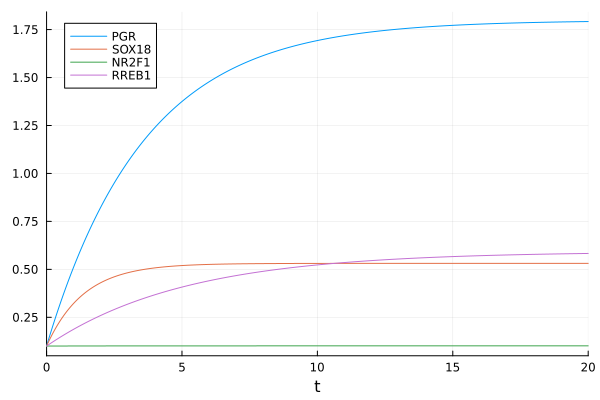

In [24]:
using DifferentialEquations, ModelingToolkit, Plots


# initial conditions
u0 = Dict(var => 0.1 for var in unknowns(subset_sys))
p  = Dict(param => rand() for param in parameters(subset_sys))

prob = ODEProblem(subset_complete, merge(u0,p), (0.0,20.0))
sol = solve(prob, Tsit5())
plot(sol, vars=[Symbol("PGR"), Symbol("SOX18"), Symbol("NR2F1"), Symbol("RREB1")])

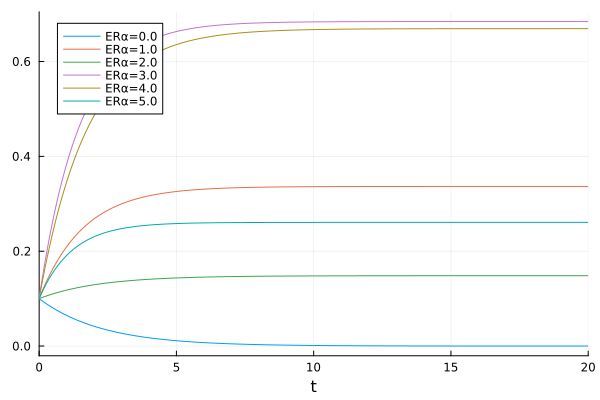

In [22]:
using DifferentialEquations, Plots

# find the ERalpha parameter object directly
ERα = only(parameters(subset_sys)[string.(parameters(subset_sys)) .== "ERalpha"])

u0 = Dict(var => 0.1 for var in unknowns(subset_sys))

plot()
for val in 0.0:1.0:5.0
    # parameters all = 1.0
    p = Dict(param => rand() for param in parameters(subset_sys))
    # set driver ERalpha
    p[ERα] = val

    prob = ODEProblem(subset_complete, merge(u0,p), (0.0,20.0))
    sol = solve(prob, Tsit5())

    plot!(sol, vars=[@variables PGR(t)], label="ERα=$(val)")
end

plot!()


## Full GRN Simulation

### BaseMean provides a proxy for $X_{\infty}$

In [ ]:
expr_map = Dict(
    row.target => row.baseMean
    for row in eachrow(unique(edges, :target))
)

Dict{String15, Float64} with 507 entries:
  "COASY"    => 392.185
  "ELMSAN1"  => 1554.6
  "FSCN1"    => 1541.31
  "LSR"      => 162.801
  "IKZF2"    => 313.041
  "ADRA1A"   => 984.945
  "AGAP2"    => 5957.47
  "GLRX"     => 482.397
  "RREB1"    => 1321.48
  "GLI2"     => 135.841
  "MITF"     => 50.139
  "SAMD4"    => 2157.34
  "ARHGEF1"  => 717.749
  "CRB2"     => 75.5682
  "MEF2A"    => 1243.13
  "HIVEP2"   => 6667.37
  "FMN1"     => 393.376
  "METTL8"   => 170.955
  "SERPINI1" => 1303.43
  ⋮          => ⋮

### Defining $\alpha$ // degradation rate

We defined gene expression as 

$$
\frac{dG}{dt} = \text{production} - \alpha G
$$

therefore $\displaystyle{G(t) = G(0)\cdot e^{-\alpha t}}$ which is the general equation for **any** system defined by first-order exponential decay with half-life as follows

$$
t_{\frac{1}{2}} = \frac{\ln (2)}{\alpha}
$$

Agarwal et al., 2022 compiled a robust estimate of the half-lives of various genes using PCA where PC1 provided a cell-type-agnostic estimate of half-life

##### Importing $t_{\frac{1}{2}}$ PC1 estimates

In [2]:
using XLSX, DataFrames

t_half_path = "data/half-lives/Agarwal2022-PC1-half-lives.xlsx"
t_half_xf = XLSX.readxlsx(t_half_path)
t_half_sheets = XLSX.sheetnames(t_half_xf)
for (i, name) in enumerate(t_half_sheets)
    println("Sheet $i: $name")
end

Sheet 1: human
Sheet 2: mouse


In [37]:
t_half_df = DataFrame(
    XLSX.gettable(
        t_half_xf["mouse"], 
        # "A:C"; 
        first_row=3
    )
)
rename!(
    t_half_df, 
    "Gene name" => :gene,
    "half-life (PC1)" => :pc1
)
t_half_df.gene = uppercase.(t_half_df.gene)
t_half_df = filter(
    row -> uppercase(row.gene) in genes,
    t_half_df
)

# Aggregate training examples for regression model

studies = names(t_half_df)[4:end]

stacked = stack(
    t_half_df, studies; 
    variable_name = :study,
    value_name = :log10_half_life
)

dropmissing!(stacked, :log10_half_life)
stacked.pc1 = Float64.(stacked.pc1)
stacked.log10_half_life = Float64.(stacked.log10_half_life)

# Regression to calculate t_1/2 from pc1

using GLM
model = lm(@formula(log10_half_life ~ pc1), stacked)


t_half_df.t_half_hours = 10 .^ predict(model, t_half_df)
t_half_map = Dict(row.gene => row.t_half_hours for row in eachrow(t_half_df))

nothing

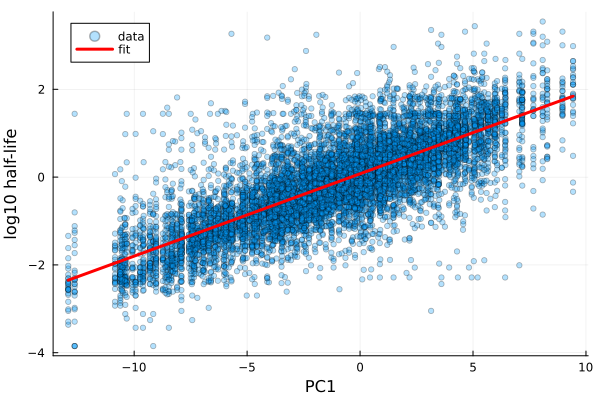

In [51]:
using StatsPlots

@df stacked scatter(
    :pc1, :log10_half_life;
    alpha = 0.3, ms = 3, label = "data", xlabel = "PC1", ylabel = "log10 half-life"
)

xs = range(minimum(stacked.pc1), maximum(stacked.pc1), length = 210)
ys = coef(model)[1] .+ coef(model)[2] .* xs

plot!(xs, ys, color=:red, lw = 3, label = "fit")

#### $\alpha$ function

Above we defined alpha as $\displaystyle{\alpha = \frac{\ln(2)}{t_{\frac{1}{2}}}}$ where $t_{\frac{1}{2}}$ is in hours (same units as Agarwal's PC1)

here we will use this estimate to sample half-life values for gene $i$ from a log-normal distribution with $\mu_{i} = \log\left( t_{\frac{1}{2}, i}^{\text{atlas}} \right)$ with $\sigma_{i} \sim 0.3$

$$
\log t_{\frac{1}{2}, i} \sim \mathcal{N}(\mu_{i}, \sigma_{i})
$$

such that $t_{\frac{1}{2}, i} = \exp\left( \log t_{\frac{1}{2}, i} \right)$ which can then be used to compute $\alpha$ as

$$
\alpha = \frac{\ln(2)}{t_{\frac{1}{2}, i}}
$$




In [38]:
using Distributions, Serialization

function sample_alpha(gene::String, μ::Float64, TFs::Set{String})

    σ = (gene in TFs) ? 0.5 : 0.2 # TFs are more variable/less stable
    dist = Normal(log(μ), σ)
    t_half_sample = exp(rand(dist))

    return log(2)/t_half_sample

end

mouseTFs = deserialize("output/mouseTFs.jls")
alpha_map = Dict(gene => sample_alpha(gene, t_half_pc1, mouseTFs) for (gene, t_half_pc1) in t_half_map)

Dict{String, Float64} with 481 entries:
  "FSCN1"    => 0.182014
  "CREB1"    => 3.61913
  "EHD1"     => 0.522213
  "IKZF2"    => 3.70836
  "ADRA1A"   => 0.803477
  "GLRX"     => 0.411561
  "AGAP2"    => 0.642268
  "RREB1"    => 7.9585
  "GLI2"     => 0.997226
  "MITF"     => 1.61565
  "SAMD4"    => 2.58618
  "CRB2"     => 0.63362
  "ARHGEF1"  => 0.0832501
  "MEF2A"    => 2.97428
  "HIVEP2"   => 5.40135
  "FMN1"     => 2.01041
  "METTL8"   => 0.560197
  "SERPINI1" => 0.592306
  "JUP"      => 0.129065
  ⋮          => ⋮

### Defining $\beta$ // Max. Production

We can back calculate $\beta$ from $X_{\infty}$ from our original ODE definition

$$
\beta = X_{\infty} * \alpha
$$

RNA-seq `baseMean` provides a "scaled-concentration" which we can use as a proxy for $X_{\infty}$

In [53]:
median_expr = median(values(expr_map))
expr_map_norm = Dict(g => expr/median_expr for (g, expr) in expr_map)

beta_map = Dict(
    g => alpha_map[g] * expr_map_norm[g]
    for g in keys(alpha_map) if haskey(expr_map_norm, g)
)


Dict{String, Float64} with 481 entries:
  "FSCN1"    => 0.37365
  "COASY"    => 0.374484
  "CPEB4"    => 7.51238
  "IKZF2"    => 1.54616
  "ADRA1A"   => 1.05404
  "GLRX"     => 0.264429
  "AGAP2"    => 5.09622
  "RREB1"    => 14.0076
  "GLI2"     => 0.180424
  "MITF"     => 0.107893
  "SAMD4"    => 7.43102
  "CRB2"     => 0.0637732
  "ARHGEF1"  => 0.0795844
  "MEF2A"    => 4.92455
  "HIVEP2"   => 47.9653
  "FMN1"     => 1.05333
  "METTL8"   => 0.127554
  "SERPINI1" => 1.02827
  "JUP"      => 0.130288
  ⋮          => ⋮

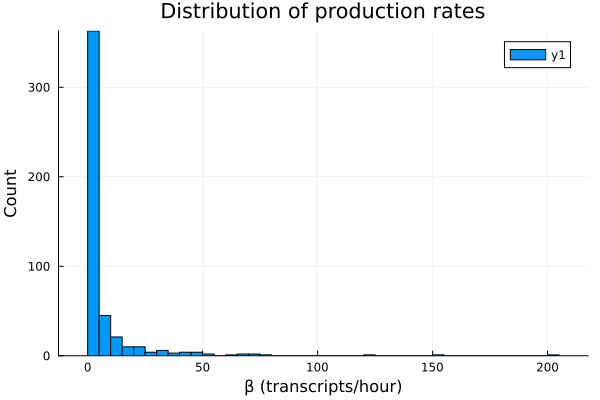

In [54]:
using StatsPlots

histogram((collect(values(beta_map))), bins=50,
          xlabel="β (transcripts/hour)", ylabel="Count",
          title="Distribution of production rates")


22-element Vector{String}:
 "SUSD5"
 "RCN1"
 "RFX2"
 "BRINP2"
 "MARVELD3"
 "NGFR"
 "MOB3C"
 "PHLDA1"
 "PTCHD2"
 "NXN"
 ⋮
 "DENR"
 "PALB2"
 "GLIS2"
 "ZAN"
 "FANCM"
 "ITGA7"
 "GPR160"
 "2310030G06RIK"
 "2310033P09RIK"